In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor

# 1. Preparation

In [12]:
class FinancialXGBoostPipeline:
    def __init__(self, target_col, n_estimators=1000, learning_rate=0.01, max_depth=5):
        self.target_col = target_col
        self.model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
            random_state=42,
            early_stopping_rounds=50,
            objective='reg:squarederror'
        )
        self.scaler = StandardScaler()
        self.feature_cols = []

    def create_features(self, df):
        """
        Tạo các đặc trưng kỹ thuật (Lags, Rolling) để mô hình hiểu ngữ cảnh thời gian.
        Đây là bước quan trọng nhất để tránh dự đoán = 0.
        """
        data = df.copy()
        
        # 1. Tạo Lags (Độ trễ) cho Target và Volume
        # Giá hôm nay phụ thuộc vào giá 1, 2, 3 ngày trước
        lags = [1, 2, 3, 5] 
        for lag in lags:
            data[f'lag_{lag}_{self.target_col}'] = data[self.target_col].shift(lag)
            if 'fpt_stock_volume_log_return' in data.columns:
                data[f'lag_{lag}_volume'] = data['fpt_stock_volume_log_return'].shift(lag)

        # 2. Rolling Statistics (Thống kê trượt)
        # Bắt tín hiệu xu hướng (Mean) và độ biến động (Std) trong 7 và 14 ngày qua
        windows = [7, 14]
        for window in windows:
            data[f'roll_mean_{window}'] = data[self.target_col].rolling(window=window).mean().shift(1)
            data[f'roll_std_{window}'] = data[self.target_col].rolling(window=window).std().shift(1)

        # Loại bỏ các dòng NaN do shift/rolling tạo ra
        data = data.dropna()
        return data

    def preprocess(self, df, train_ratio=0.8):
        print("--- [1] Feature Engineering & Preprocessing ---")
        
        # 1. Tạo Features mới
        df_featured = self.create_features(df)
        
        # 2. Xác định Features và Target
        # Loại bỏ các cột không dùng để train (như cột giá gốc nếu có)
        drop_cols = [self.target_col]
        if 'fpt_stock_price' in df_featured.columns: drop_cols.append('fpt_stock_price')
        if 'fpt_stock_price_log_return_scaled' in df_featured.columns: drop_cols.append('fpt_stock_price_log_return_scaled')
        
        self.feature_cols = [c for c in df_featured.columns if c not in drop_cols]
        print(f"Features created ({len(self.feature_cols)}): {self.feature_cols}")

        X = df_featured[self.feature_cols].values
        y = df_featured[self.target_col].values

        # 3. Chia Train/Test theo thời gian (Không shuffle!)
        split_idx = int(len(X) * train_ratio)
        X_train, y_train = X[:split_idx], y[:split_idx]
        X_test, y_test = X[split_idx:], y[split_idx:]
        
        # Lưu index (ngày) để vẽ biểu đồ cho đẹp
        self.test_dates = df_featured.index[split_idx:]

        print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")
        
        return X_train, y_train, X_test, y_test

    def train(self, X_train, y_train, X_test, y_test):
        print("--- [2] Training XGBoost ---")
        
        # Train với eval_set là tập test để theo dõi overfitting
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False
        )
        print("Training Completed.")
        return self.model.evals_result()

    def evaluate(self, X_test, y_test):
        print("--- [3] Evaluation ---")
        preds = self.model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Tính Directional Accuracy (Quan trọng hơn RMSE trong tài chính)
        # Dự đoán đúng chiều tăng/giảm
        correct_direction = np.mean(np.sign(preds) == np.sign(y_test))
        
        print(f"RMSE : {rmse:.5f}")
        print(f"MAE  : {mae:.5f}")
        print(f"R2   : {r2:.5f}")
        print(f"Directional Accuracy: {correct_direction:.2%}")
        
        return pd.DataFrame({'Actual': y_test, 'Predicted': preds}, index=self.test_dates)

    def visualize(self, result_df):
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Actual vs Predicted
        plt.subplot(2, 1, 1)
        plt.plot(result_df.index, result_df['Actual'], label='Actual (Real)', color='blue', alpha=0.5, linewidth=1)
        plt.plot(result_df.index, result_df['Predicted'], label='XGBoost Prediction', color='red', linewidth=1.5)
        plt.title(f'XGBoost Prediction vs Actual Log Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Zoom in vào 100 ngày cuối (để thấy rõ nó có bám 0 hay không)
        plt.subplot(2, 1, 2)
        tail_df = result_df.tail(100)
        plt.plot(tail_df.index, tail_df['Actual'], label='Actual', color='blue', marker='o', markersize=3, alpha=0.5)
        plt.plot(tail_df.index, tail_df['Predicted'], label='Prediction', color='red', marker='x', markersize=3)
        plt.title('Zoomed In (Last 100 Days)')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Đường 0
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Plot 3: Feature Importance
        plt.figure(figsize=(12, 6))
        xgb.plot_importance(self.model, max_num_features=15, height=0.5)
        plt.title("Top 15 Feature Importance")
        plt.show()

# 2. Main Pipeline

# 3. Pipeline

In [5]:
df = pd.read_csv(r'..\..\data\predictive_modeling.csv', index_col='date')
df.head()

,fpt_stock_price_log_return_scaled,market_cap_log_return,fpt_stock_price_log_return,gdp_value,cpi_rate,fpt_stock_price,fpt_stock_volume_log_return,fpt_net_revenue_log_return,usd_vnd_rate_log_return,xau_usd_rate_log_return
date,,,,,,,,,,
2020-01-01,-0.055765,0.0,0.000000,3.466157e+11,0.0643,21.39,0.000000,0.0,0.000194,0.009066
2020-01-02,-0.055765,0.0,0.000000,3.466157e+11,0.0643,21.39,0.000000,0.0,0.000194,0.009066
2020-01-03,-1.040504,0.0,-0.016974,3.466157e+11,0.0643,21.03,0.825817,0.0,-0.000043,0.014361
2020-01-06,-0.665883,0.0,-0.010516,3.466157e+11,0.0643,20.81,-0.629106,0.0,0.000151,0.018648
2020-01-07,1.048811,0.0,0.019039,3.466157e+11,0.0643,21.21,-0.265344,0.0,0.000043,-0.003361


In [13]:
cols_to_drop = ['fpt_stock_price', 'fpt_stock_price_log_return_scaled']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')
print("Các cột còn lại sau khi drop:\n", df_clean.columns)

Các cột còn lại sau khi drop:
 Index(['market_cap_log_return', 'fpt_stock_price_log_return', 'gdp_value',
       'cpi_rate', 'fpt_stock_volume_log_return', 'fpt_net_revenue_log_return',
       'usd_vnd_rate_log_return', 'xau_usd_rate_log_return'],
      dtype='object')


In [14]:
pipeline = FinancialXGBoostPipeline(
    target_col='fpt_stock_price_log_return',
    n_estimators=2000, 
    learning_rate=0.03, 
    max_depth=4
)

--- [1] Feature Engineering & Preprocessing ---
Features created (19): ['market_cap_log_return', 'gdp_value', 'cpi_rate', 'fpt_stock_volume_log_return', 'fpt_net_revenue_log_return', 'usd_vnd_rate_log_return', 'xau_usd_rate_log_return', 'lag_1_fpt_stock_price_log_return', 'lag_1_volume', 'lag_2_fpt_stock_price_log_return', 'lag_2_volume', 'lag_3_fpt_stock_price_log_return', 'lag_3_volume', 'lag_5_fpt_stock_price_log_return', 'lag_5_volume', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14']
Train Size: 1212 | Test Size: 303
--- [2] Training XGBoost ---
Training Completed.
--- [3] Evaluation ---
RMSE : 0.01608
MAE  : 0.01091
R2   : 0.10370
Directional Accuracy: 53.47%


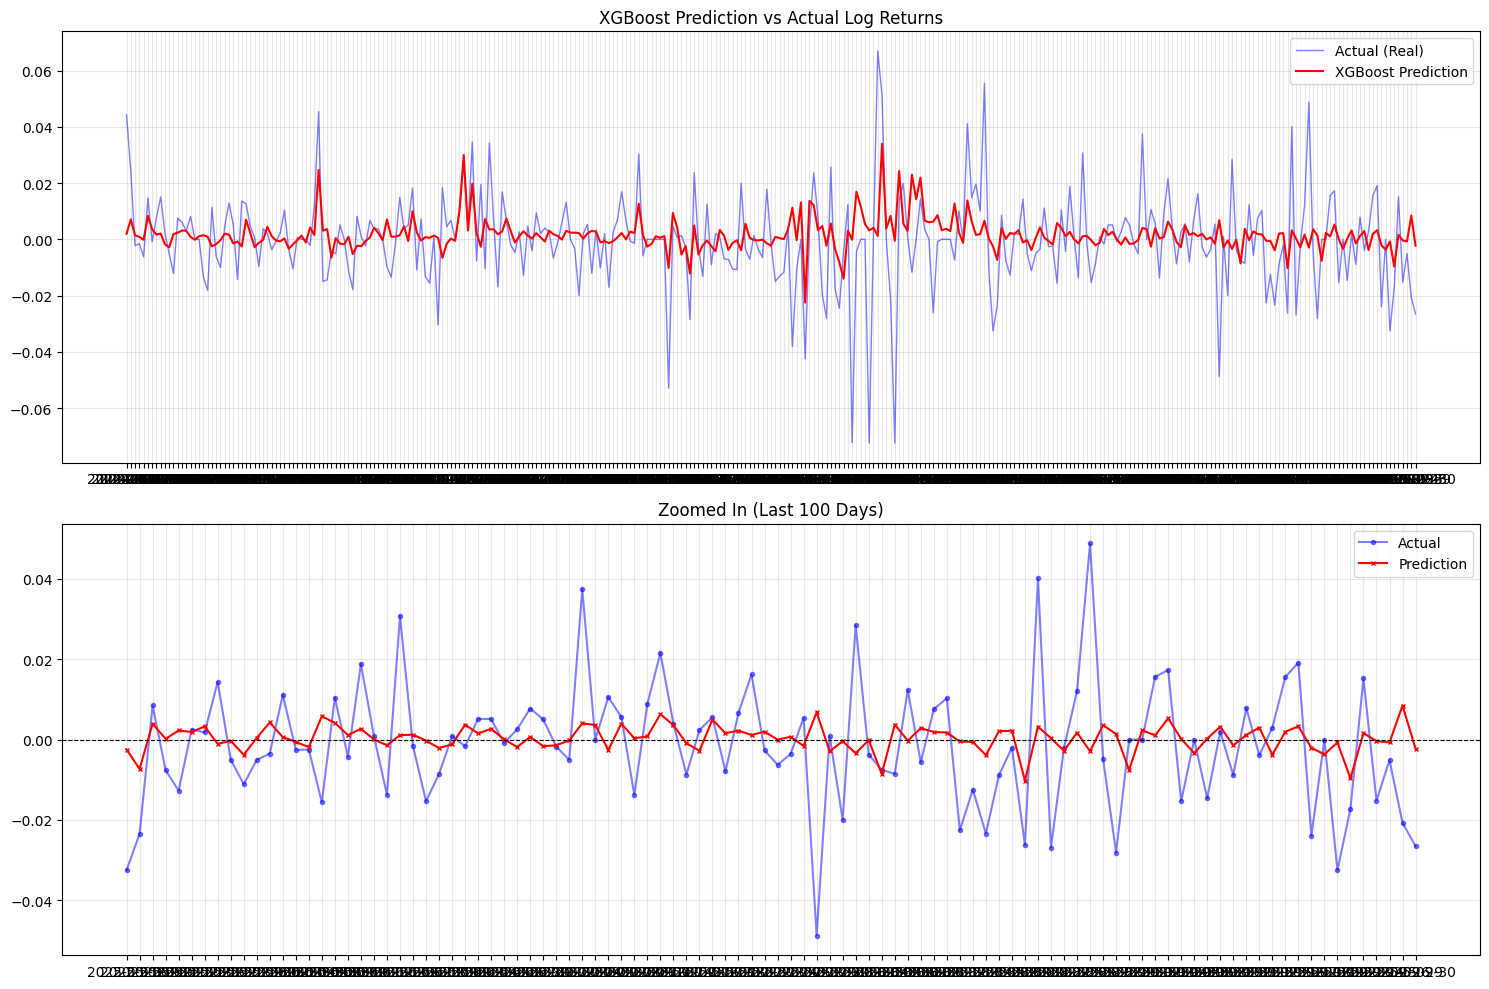

<Figure size 1200x600 with 0 Axes>

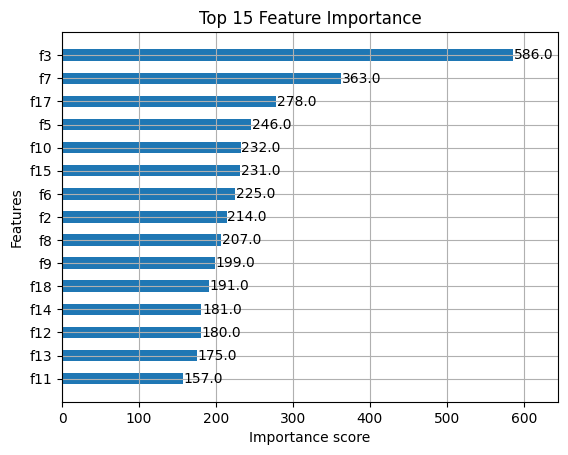

In [15]:
X_train, y_train, X_test, y_test = pipeline.preprocess(df)
history = pipeline.train(X_train, y_train, X_test, y_test)
results = pipeline.evaluate(X_test, y_test)
pipeline.visualize(results)